# Graph 

In [1]:
from __future__ import print_function
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; } </style>"))

In [2]:
from pkg.robots_custom import *
xcustom = XacroCustomizer()

In [3]:
from enum import Enum
class Scenario(Enum):
    single_object_single_robot = 0
    double_object_single_robot = 1
    single_object_dual_robot = 2
    assembly_3_piece = 3
    custom_robots = 4

In [4]:
current_scenario = Scenario.custom_robots

In [5]:
urdf_content = None
if current_scenario in [Scenario.single_object_dual_robot, Scenario.assembly_3_piece]:
    from pkg.ur10_dual import URDF_PATH, JOINT_NAMES, LINK_NAMES, ZERO_JOINT_POSE, get_geometry_items_dict
elif current_scenario in [Scenario.single_object_single_robot, Scenario.double_object_single_robot]:
    from pkg.ur10 import URDF_PATH, JOINT_NAMES, LINK_NAMES, ZERO_JOINT_POSE, get_geometry_items_dict
else:
    xcustom.clear()
    xcustom.add_robot(RobotType.indy7_robot, xyz=[0,-0.5,0], rpy= [0,0,0])
    xcustom.add_robot(RobotType.panda_robot, xyz=[0,0.5,0], rpy= [0,0,0])
    xcustom.write_xacro()
    JOINT_NAMES, LINK_NAMES, ZERO_JOINT_POSE, urdf_content = \
            xcustom.convert_xacro_to_urdf(joint_fix_dict={'finger':'upper'})
    ZERO_JOINT_POSE = np.array([0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 1.57079633, 0. ])
    xcustom.start_rviz()
    
from pkg.constraint_graph import *
import matplotlib.pyplot as plt
from pkg.plot_utils import *
from pkg.utils import *
# from threading import Thread, Lock
from multiprocessing import Process, Lock, Manager
PROC_MODE = True

Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran0']/actuator[@name='indy0_motor0']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran1']/actuator[@name='indy0_motor1']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran2']/actuator[@name='indy0_motor2']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran3']/actuator[@name='indy0_motor3']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran4']/actuator[@name='indy0_motor4']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran5']/actuator[@name='indy0_motor5']


In [24]:
graph = ConstraintGraph(urdf_path=URDF_PATH, joint_names=JOINT_NAMES, link_names=LINK_NAMES, urdf_content=urdf_content)
# graph.set_fixed_geometry_items(geometry_items_dict)
# graph.set_fixed_geometry_items({link:[] for link in LINK_NAMES})
graph.set_fixed_geometry_items(
    get_geometry_items_dict(graph.urdf_content, color=(0,1,0,0.5), display=True, collision=True, exclude_link=["panda1_link7"]))

In [25]:
graph.set_simulation(nWSR=50, regularization_factor= 1e-1)

publication OK
published: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
publication OK
publication OK
publication OK
publication OK
publication OK
publication OK
publication OK
publication OK
publication OK
publication OK
publication OK
publication OK
publication OK
publication OK
publication OK
publication OK
publication OK
publication OK
publication OK
publication OK
publication OK
publication OK
publication OK
publication OK


In [26]:
graph.show_pose(ZERO_JOINT_POSE)

# Single object

In [27]:
if current_scenario == Scenario.single_object_single_robot:
    collision = True
    graph.add_geometry_items("world", 
                              [
                               GeoMesh(uri="package://my_mesh/meshes/stl/AirPick_cup_ctd.stl", BLH=(0.01,0.01,0.01), scale=(1e-3,1e-3,1e-3), name="gripper1", link_name="tool0", urdf_content=graph.urdf_content, color=(0.1,0.1,0.1,1), collision=collision),
                               GeoBox((0.5,-0.2,0.050), (0.1,0.1,0.1), name="box1", link_name="world", urdf_content=graph.urdf_content, color=(0.3,0.3,0.8,1), collision=collision),
                               GeoBox((0,0,-0.005), (3,3,0.01), name="floor", link_name="world", urdf_content=graph.urdf_content, color=(0.6,0.6,0.6,1), collision=collision),
                               GeoBox((0.7,0.0,0.2), (0.7,0.05,0.4), name="wall", link_name="world", urdf_content=graph.urdf_content, color=(0.4,0.3,0.0,1), collision=collision),
                               GeoBox((0.4,0.4,0.15), (0.15,0.15,0.3), name="stepper", link_name="world", urdf_content=graph.urdf_content, color=(0.4,0.3,0.0,1), collision=collision),
                               GeoBox((0.4,0.4,0.3), (0.1,0.1,1e-3), name="goal_disp", link_name="world", urdf_content=graph.urdf_content, color=(0.8,0.0,0.0,1),
                                      collision=False)])
    
    graph.register_binder(name='vac1', _type=VacuumTool, point=[0,0,5e-2], link_name="tool0", direction=[0,0,1])
    graph.register_binder(name='floor', _type=PlacePlane, direction=[0,0,1])
    graph.register_binder(name='goal', _type=PlaceFrame, point=(0.4,0.4,0.3+5e-4), link_name="world", orientation=[0,0,0])

    graph.register_object('box1', _type=BoxAction, binding=("bottom_p","floor"))

    graph.update_handles()

# Double object

In [28]:
if current_scenario == Scenario.double_object_single_robot:
    graph.add_geometry_items("world", [
        GeoBox((0,0,-0.005), (3,3,0.01), name="floor", link_name="world", urdf_content=graph.urdf_content, color=(0.6,0.6,0.6,1)),
        GeoBox((0.7,0.0,0.2), (0.7,0.05,0.4), name="wall", link_name="world", urdf_content=graph.urdf_content, color=(0.4,0.3,0.0,1)),
        GeoBox((0.5,-0.2,0.050), (0.1,0.1,0.1), name="box1", link_name="world", urdf_content=graph.urdf_content, color=(0.3,0.3,0.8,1)),
        GeoBox((0.4,-0.3,0.050), (0.1,0.1,0.1), name="box2", link_name="world", urdf_content=graph.urdf_content, color=(0.8,0.8,0.3,1)),
        GeoBox((0.4,0.4,0.15), (0.3,0.3,0.3), name="stepper1", link_name="world", urdf_content=graph.urdf_content, color=(0.4,0.3,0.0,1)),
        GeoBox((-0.1,-0.4,0.15), (0.3,0.3,0.3), name="stepper2", link_name="world", urdf_content=graph.urdf_content, color=(0.4,0.3,0.0,1)),
        GeoBox((0.4,0.4,0.3), (0.2,0.2,1e-3), name="goal1_disp", link_name="world", urdf_content=graph.urdf_content, color=(0.0,0.0,0.8,1),
               collision=False),
        GeoBox((-0.1,-0.4,0.3), (0.2,0.2,1e-3), name="goal2_disp", link_name="world", urdf_content=graph.urdf_content, color=(0.8,0.8,0.0,1),
               collision=False)])
    
    graph.register_binder(name='vac1', _type=VacuumTool, point=[0,0,1e-3], link_name="tool0", direction=[0,0,1])
    
    graph.register_binder(name='floor', _type=PlacePlane, direction=[0,0,1])

    graph.register_object('box1', _type=BoxAction, binding=("bottom_p", "floor"), hexahedral=True)
    graph.register_object('box2', _type=BoxAction, binding=("bottom_p", "floor"), hexahedral=True)
    graph.register_binder(name='box11', _type=PlacePlane, object_name="box1", point=[0,0,0.05], direction=[0,0,1])
    graph.register_binder(name='box12', _type=PlacePlane, object_name="box1", point=[0.05,0,0.05], direction=[0,0,1])
    graph.register_binder(name='box2', _type=PlacePlane, point=[0,0,0.05], direction=[0,0,1])
    graph.register_binder(name='goal1', _type=PlacePlane, point=(0.4,0.4,0.3), link_name="world", direction=[0,0,1])
    graph.register_binder(name='goal2', _type=PlacePlane, point=(-0.1,-0.4,0.3+5e-4), link_name="world", direction=[0,0,1])

    graph.update_handles()

# Single object Dual robot

In [29]:
if current_scenario == Scenario.single_object_dual_robot:
    graph.add_geometry_items("world", [
        GeoMesh(uri="package://my_mesh/meshes/stl/AirPick_cup_ctd.stl", BLH=(0.01,0.01,0.01), scale=(1e-3,1e-3,1e-3), name="gripper1", link_name="tool0_1", urdf_content=graph.urdf_content, color=(0.1,0.1,0.1,1)),
        GeoMesh(uri="package://my_mesh/meshes/stl/AirPick_cup_ctd.stl", BLH=(0.01,0.01,0.01), scale=(1e-3,1e-3,1e-3), name="gripper2", link_name="tool0_2", urdf_content=graph.urdf_content, color=(0.1,0.1,0.1,1)),
        GeoBox((0,0,-0.005), (3,3,0.01), name="floor", link_name="world", urdf_content=graph.urdf_content, color=(1,1,1,1)),
        GeoBox((-1,0.0,2.5), (0.1,10.0,5), name="wall_back", link_name="world", urdf_content=graph.urdf_content, color=(1,1,1,1)),
        GeoBox((0,0.0,0.10), (2.0,0.03,0.20), name="wall1", link_name="world", urdf_content=graph.urdf_content, color=(0.4,0.3,0.0,1)),
        GeoBox((0,0.0,1.4), (2.0,0.03,2), name="wall2", link_name="world", urdf_content=graph.urdf_content, color=(0.4,0.3,0.0,1)),
        GeoBox((0.5,-0.2,0.050), (0.1,0.1,0.1), name="box1", link_name="world", urdf_content=graph.urdf_content, color=(0.3,0.3,0.8,1)),
        GeoBox((0.4,0.4,0.0), (0.2,0.2,1e-3), name="goal_disp", link_name="world", urdf_content=graph.urdf_content, color=(0.0,0.0,0.8,1),
               collision=False)])
#         GeoBox((-1,0.0,2.5), (0.1,10.0,5), name="wall_back", link_name="world", urdf_content=graph.urdf_content, color=(1,1,1,1)),
#         GeoBox((0,0.0,0.0), (2.0,0.03,0.01), name="wall1", link_name="world", urdf_content=graph.urdf_content, color=(0.4,0.3,0.0,1)), # no wall
#         GeoBox((0,0.0,2), (2.0,0.03,0.01), name="wall2", link_name="world", urdf_content=graph.urdf_content, color=(0.4,0.3,0.0,1)), # no wall
#         GeoBox((0,0.0,0.10), (2.0,0.03,0.20), name="wall1", link_name="world", urdf_content=graph.urdf_content, color=(0.4,0.3,0.0,1)), # lower wall
#         GeoBox((0,0.0,2), (2.0,0.03,0.01), name="wall2", link_name="world", urdf_content=graph.urdf_content, color=(0.4,0.3,0.0,1)), # lower wall
#         GeoBox((0,0.0,0.10), (2.0,0.03,0.20), name="wall1", link_name="world", urdf_content=graph.urdf_content, color=(0.4,0.3,0.0,1)), # 40cm
#         GeoBox((0,0.0,1.6), (2.0,0.03,2), name="wall2", link_name="world", urdf_content=graph.urdf_content, color=(0.4,0.3,0.0,1)), # 40cm
#         GeoBox((0,0.0,0.10), (2.0,0.03,0.20), name="wall1", link_name="world", urdf_content=graph.urdf_content, color=(0.4,0.3,0.0,1)), # 20cm
#         GeoBox((0,0.0,1.4), (2.0,0.03,2), name="wall2", link_name="world", urdf_content=graph.urdf_content, color=(0.4,0.3,0.0,1)), # 20cm
    
    graph.register_binder(name='vac1', _type=VacuumTool, point=[0,0,5e-2], link_name="tool0_1", direction=[0,0,1])
    graph.register_binder(name='vac2', _type=VacuumTool, point=[0,0,5e-2], link_name="tool0_2", direction=[0,0,1])
    
    graph.register_binder(name='floor', _type=PlacePlane, direction=[0,0,1])
    graph.register_binder(name='goal1', _type=PlacePlane, point=(0.4,0.4,0.0+5e-4), link_name="world", direction=[0,0,1])
    graph.register_object('box1', _type=BoxAction, binding=("bottom_p", "floor"), hexahedral=True)

    graph.update_handles()

# Assembly 3 piece

In [30]:
if current_scenario == Scenario.assembly_3_piece:
    graph.add_geometry_items("world", [
        GeoMesh(uri="package://my_mesh/meshes/stl/AirPick_cup_ctd.stl", BLH=(0.01,0.01,0.01), scale=(1e-3,1e-3,1e-3), name="gripper1", link_name="tool0_1", urdf_content=graph.urdf_content, color=(0.1,0.1,0.1,1)),
        GeoMesh(uri="package://my_mesh/meshes/stl/AirPick_cup_ctd.stl", BLH=(0.01,0.01,0.01), scale=(1e-3,1e-3,1e-3), name="gripper2", link_name="tool0_2", urdf_content=graph.urdf_content, color=(0.1,0.1,0.1,1)),
        GeoBox((0,0,-0.005), (10,10,0.01), name="floor", link_name="world", urdf_content=graph.urdf_content, color=(1,1,1,1)),
        GeoBox((-1,0.0,2.5), (0.1,10.0,5), name="wall_back", link_name="world", urdf_content=graph.urdf_content, color=(1,1,1,1)),
        GeoBox((0.5,0.0,0.050), (0.1,0.4,0.1), name="box1", link_name="world", urdf_content=graph.urdf_content, color=(0.3,0.3,0.8,1)),
        GeoBox((0.5,0.3,0.050), (0.1,0.1,0.1), name="box2", link_name="world", urdf_content=graph.urdf_content, color=(0.8,0.3,0.3,1)),
        GeoBox((0.5,-0.3,0.050), (0.1,0.1,0.1), name="box3", link_name="world", urdf_content=graph.urdf_content, color=(0.8,0.3,0.3,1)),
        GeoBox((0.5,-1.1,0.0), (0.2,0.2,1e-3), name="goal_disp", link_name="world", urdf_content=graph.urdf_content, color=(0.0,0.0,0.8,1),
               collision=False)])
#        GeoBox((0.4,0.4,0.15), (0.3,0.3,0.3), name="stepper1", link_name="world", urdf_content=graph.urdf_content, color=(0.4,0.3,0.0,1)),
    
    graph.register_binder(name='vac1', _type=VacuumTool, point=[0,0,5e-2], link_name="tool0_1", direction=[0,0,1])
    graph.register_binder(name='vac2', _type=VacuumTool, point=[0,0,5e-2], link_name="tool0_2", direction=[0,0,1])
    
    graph.register_binder(name='floor', _type=PlacePlane, direction=[0,0,1])
    graph.register_binder(name='goal1', _type=PlacePlane, point=(0.5,-1.1,0.0+5e-4), link_name="world", direction=[0,0,1])
    graph.register_binder(name='asm1', _type=PlaceFrame, object_name="box1", point=[0,0.15,0.05], orientation=(0,0,0))
    graph.register_binder(name='asm2', _type=PlaceFrame, object_name="box1", point=[0,-0.15,0.05], orientation=(0,0,0))

    graph.register_object('box1', _type=BoxAction, binding=("bottom_p", "floor"))
    graph.register_object('box2', _type=BoxAction, binding=("bottom_p", "floor"))
    graph.register_object('box3', _type=BoxAction, binding=("bottom_p", "floor"))

    graph.update_handles()

# Custom Robots

In [31]:
if current_scenario == Scenario.custom_robots:
    collision=True
    graph.add_geometry_items("world", 
                              [
                               GeoMesh(uri="package://my_mesh/meshes/stl/AirPick_cup_ctd.stl", BLH=(0.01,0.01,0.01), scale=(1e-3,1e-3,1e-3), name="gripper1", link_name="indy0_tcp", urdf_content=graph.urdf_content, color=(0.1,0.1,0.1,1), collision=collision),
                               GeoBox((0.5,-0.2,0.050), (0.05,0.05,0.05), name="box1", link_name="world", urdf_content=graph.urdf_content, color=(0.3,0.3,0.8,1), collision=collision),
                               GeoBox((0,0,-0.005), (3,3,0.01), name="floor", link_name="world", urdf_content=graph.urdf_content, color=(0.6,0.6,0.6,1), collision=collision),
                               GeoBox((0.7,0.0,0.2), (0.7,0.05,0.4), name="wall", link_name="world", urdf_content=graph.urdf_content, color=(0.4,0.3,0.0,1), collision=collision),
                               GeoBox((0.4,0.4,0.15), (0.15,0.15,0.3), name="stepper", link_name="world", urdf_content=graph.urdf_content, color=(0.4,0.3,0.0,1), collision=collision),
                               GeoBox((0.4,0.4,0.3), (0.1,0.1,1e-3), name="goal_disp", link_name="world", urdf_content=graph.urdf_content, color=(0.8,0.0,0.0,1),
                                      collision=False)])
    
    graph.register_binder(name='vac1', _type=VacuumTool, point=[0,0,7e-2], link_name="panda1_link8", direction=[0,0,1])
    graph.register_binder(name='vac2', _type=VacuumTool, point=[0,0,5e-2], link_name="indy0_tcp", direction=[0,0,1])
    graph.register_binder(name='floor', _type=PlacePlane, direction=[0,0,1])
    graph.register_binder(name='goal', _type=PlaceFrame, point=(0.4,0.4,0.3+5e-4), link_name="world", orientation=[0,0,0])

    graph.register_object('box1', _type=BoxAction, binding=("bottom_p","floor"))

    graph.update_handles()

# Set RVIZ

In [32]:
graph.set_simulation(nWSR=50, regularization_factor= 1e-1)

publication OK
published: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
publication OK
publication OK
publication OK
publication OK
publication OK
publication OK
publication OK
publication OK
publication OK
publication OK
publication OK
publication OK
publication OK
publication OK
publication OK
publication OK
publication OK
publication OK
publication OK
publication OK
publication OK
publication OK
publication OK
publication OK
publication OK
publication OK
publication OK
publication OK
publication OK
publication OK


In [33]:
graph.show_pose(ZERO_JOINT_POSE)

In [35]:
joint_num = len(graph.joint_names)

In [ ]:
N = 300
dt = 1e-2

from_state = State((('box1','bottom_p','floor'),), {'box1': [0.5,-0.3,0.05,0,0,0,1]}, ZERO_JOINT_POSE)
to_state = State((('box1', 'top_p', 'vac2'), ),None, None)


e, end_state, succ = graph.simulate_transition(from_state, to_state, display=True, N=N, dt=dt, vel_conv=1e-2, err_conv=1e-3)
print(succ)

In [37]:
print(end_state)

((('box1', 'top_p', 'vac2'),), {'box1': '[ 0.    0.    0.08 -0.36  0.93  0.    0.  ]'}, '[ 0.73 -0.73 -1.78  0.   -0.63 -0.    0.   -0.   -0.   -0.07  0.    1.57\n -0.  ]')


In [20]:

# from_state = end_state
# to_state = end_state.copy()
# to_state.Q = to_state.Q +(np.random.rand(joint_num)*2-1)*np.pi/4


# e, end_state, succ = graph.simulate_transition(from_state, to_state, display=True, N=N, dt=dt, vel_conv=1e-2, err_conv=1e-3)

In [38]:
from_state = end_state
to_state = end_state.copy()
to_state.node = (('box1', 'bottom_p', 'vac1'), )

e, end_state, succ = graph.simulate_transition(from_state, to_state, display=True, N=N, dt=dt, vel_conv=1e-2, err_conv=1e-3)

start set transition: 	0 ms/0 = 0 ms 
post: 	7.0 ms/4 = 1.68 ms 



In [39]:
print(succ)

False


# build

In [34]:
graph.build_graph()

# Search Graph (Single object)

In [17]:
if current_scenario == Scenario.single_object_single_robot:
    graph.search_graph_ordered_mp(initial_state = \
                                  State((('box1','bottom_p','floor'),), 
                                        {'box1': [0.5,-0.2,0.05,0,0,0,1]}, ZERO_JOINT_POSE),
                                  goal_state = State((('box1','bottom_f','goal'),), None, None),
                                  search_num=200, display=False, N_agents = 1,
                                  terminate_on_first = True, tree_margin = 0,
                                  depth_margin = 2, joint_motion_num=50, 
                                  **dict(N=300, dt=0.01, vel_conv=1e-2, err_conv=1e-3))

# Search Graph (Double object)

In [18]:
if current_scenario == Scenario.double_object_single_robot:
    graph.search_graph_ordered_mp(initial_state = State((('box1','bottom_p','floor'),('box2','bottom_p','floor')),
                                                        {'box1': [0.5,-0.2,0.05,0,0,0,1], 'box2': [0.4,-0.3,0.05,0,0,0,1]}, ZERO_JOINT_POSE),
                                  goal_state = State((('box1','bottom_p','goal1'),('box2','bottom_p','goal2')), None, None),
                                  search_num=1000, display=False, N_agents = 12,
                                  terminate_on_first = False, tree_margin = 2,
                                  depth_margin = 3, joint_motion_num=10,
                                  **dict(N=200, dt=0.01, vel_conv=1e-2, err_conv=1e-3))

# Search Graph (Single object Dual robot)

In [19]:
if current_scenario == Scenario.single_object_dual_robot:
    graph.search_graph_ordered_mp(initial_state = State((('box1','bottom_p','floor'),),
                                                        {'box1': [0.5,-0.2,0.05,0,0,0,1]}, ZERO_JOINT_POSE),
                                  goal_state = State((('box1','bottom_p','goal1'),), None, None),
                                  search_num=3000, display=False, N_agents = 12,
                                  terminate_on_first = True, tree_margin = 0,
                                  depth_margin = 2, joint_motion_num=10,
                                  expand_depth_on_thread = True, **dict(N=200, dt=0.01, vel_conv=1e-2, err_conv=5e-4))

# Assembly 3 piece

In [20]:
if current_scenario == Scenario.assembly_3_piece:
    init_state = State(*(graph.get_object_state()+(ZERO_JOINT_POSE,)))
    goal_state = State(*((('box1', 'bottom_p', 'goal1'),
                          ('box2', 'bottom_f', 'asm1'),
                          ('box3', 'bottom_f', 'asm2')),None, None))
    graph.search_graph_ordered_mp(initial_state = init_state,
                                  goal_state = goal_state,
                                  search_num=500, display=False, N_agents = 8,
                                  terminate_on_first = True, tree_margin = 1,
                                  depth_margin = 2, joint_motion_num=10,
                                  expand_depth_on_thread = True, **dict(N=200, dt=0.01, vel_conv=1e-2, err_conv=5e-4))

# Search Graph (Custom Robots)

In [21]:
if current_scenario == Scenario.custom_robots:
    graph.search_graph_ordered(initial_state = State((('box1','bottom_p','floor'),),
                                                        {'box1': [0.5,-0.3,0.05,0,0,0,1]}, ZERO_JOINT_POSE),
                                  goal_state = State((('box1','top_f','goal'),), None, None), display=False,
                                  terminate_on_first = True, tree_margin = 4,
                                  depth_margin = 2, joint_motion_num=10, **dict(N=300, dt=0.01, vel_conv=1e-2, err_conv=5e-4))

start set transition: 	169.0 ms/1 = 169.42 ms 
set_simulate fun: 	3206.0 ms/1 = 3206.273 ms 
post: 	4.0 ms/1 = 3.912 ms 


success (0.000499082765842) - Goal cost:2->1 / Init cost:0->1 / branching: 0->1 (3.38 s)
node: (('box1', 'bottom_p', 'floor'),)->(('box1', 'top_p', 'vac2'),)
start set transition: 	377.0 ms/2 = 188.687 ms 
set_simulate fun: 	5317.0 ms/2 = 2658.474 ms 
post: 	8.0 ms/2 = 3.937 ms 


success (0.000478648848441) - Goal cost:1->2 / Init cost:1->0 / branching: 1->2 (5.7 s)
node: (('box1', 'top_p', 'vac2'),)->(('box1', 'bottom_p', 'floor'),)
start set transition: 	577.0 ms/3 = 192.364 ms 
set_simulate fun: 	6412.0 ms/3 = 2137.466 ms 
post: 	12.0 ms/3 = 4.166 ms 


success (0.00049907921988) - Goal cost:2->1 / Init cost:0->1 / branching: 2->3 (7.0 s)
node: (('box1', 'bottom_p', 'floor'),)->(('box1', 'top_p', 'vac2'),)


KeyboardInterrupt: 

In [ ]:
graph.quiver_snodes()

# Replay schedule

In [ ]:
schedule_dict = graph.find_schedules()
schedule_sorted = graph.sort_schedule(schedule_dict)
for schedule in schedule_sorted:
    print(schedule)
for schedule, i_s in zip(schedule_sorted, range(len(schedule_sorted))):
    graph.simulate_transition(graph.snode_vec[0].state, graph.snode_vec[0].state, display=True, N=100, dt=0.01, vel_conv=1e-2, err_conv=1e-3)
    timer.sleep(1)
#     try:
    e = graph.replay(schedule, N=300, dt=0.01, vel_conv=5e-2, err_conv=1e-2)
#     except Exception as e:
#         print(e)

In [ ]:
# e = graph.replay(schedule, N=1500, dt=0.002, vel_conv=1e-2, err_conv=5e-3)

In [25]:
e.displayContext()

NameError: name 'e' is not defined

# Visualize

In [ ]:
from pkg.graph_visualize import VisualGraph

In [ ]:
g = VisualGraph()

# for node, neighbor in graph.node_dict.items(): # for visualizing all
#     g.add_node(node,neighbor) # for visualizing all

for node, neighbor in graph.valid_node_dict.items():
    g.add_node(node,neighbor) # for visualizing all

# for idx in schedule: # for visualizing schedule
#     snode = graph.snode_vec[idx]
#     leafs = [(leaf, graph.snode_vec[leaf]) for leaf in snode.leafs if leaf in schedule] # for visualizing schedule
#     g.add_node("%d-"%idx+str(snode.state.node),["%d-"%i_l+str(leaf.state.node) for i_l, leaf in leafs]) # for visualizing schedule

In [ ]:
g.draw().render()
g.draw(True)

In [ ]:
g = VisualGraph()

for node, neighbor in graph.node_dict.items(): # for visualizing all
    g.add_node(node,neighbor) # for visualizing all

# for node, neighbor in graph.valid_node_dict.items():
#     leafs = ["{}-{}".format(leaf,graph.goal_cost_dict[leaf]) for leaf in neighbor] # for visualizing valid-only
#     g.add_node("{}-{}".format(node,graph.goal_cost_dict[node]), leafs) # for visualizing valid-only

# for idx in schedule: # for visualizing schedule
#     snode = graph.snode_vec[idx]
#     leafs = [(leaf, graph.snode_vec[leaf]) for leaf in snode.leafs if leaf in schedule] # for visualizing schedule
#     g.add_node("%d-"%idx+str(snode.state.node),["%d-"%i_l+str(leaf.state.node) for i_l, leaf in leafs]) # for visualizing schedule

In [ ]:
g.draw().render()
g.draw(True)

In [ ]:
def namer(node):
    if node[0][2] == 'floor':
        return 'free | free'
    if node[0][2] == 'vac1':
        return 'grasp | free'
    if node[0][2] == 'vac2':
        return 'free | grasp'
    if node[0][2] == 'goal1':
        return 'free | place'

In [ ]:
g = VisualGraph()

# for node, neighbor in graph.node_dict.items(): # for visualizing all
#     g.add_node(node,neighbor) # for visualizing all

for node, neighbor in graph.valid_node_dict.items():
#     leafs = ["{}-{}".format(leaf,graph.goal_cost_dict[leaf]) for leaf in neighbor] # for visualizing valid-only
    leafs = [namer(leaf) for leaf in neighbor] # for visualizing valid-only
    g.add_node(namer(node), leafs) # for visualizing valid-only


In [ ]:
g = VisualGraph()

for node, neighbor in graph.node_dict.items(): # for visualizing all
    g.add_node(namer(node), [namer(nd) for nd in neighbor]) # for visualizing all

# for node, neighbor in graph.valid_node_dict.items():
# #     leafs = ["{}-{}".format(leaf,graph.goal_cost_dict[leaf]) for leaf in neighbor] # for visualizing valid-only
#     leafs = [namer(leaf) for leaf in neighbor] # for visualizing valid-only
#     g.add_node(namer(node), leafs) # for visualizing valid-only


In [ ]:
g.draw().render()
g.draw(True)

# Test time

In [13]:
from pkg.utils import *

In [14]:
gtimer = GlobalTimer.instance()
gtimer.reset()

In [15]:
if current_scenario == Scenario.single_object_dual_robot:
    times = []
    iters = []
#    N_vec = [1,2,4,6,8,12,16]
    N_vec = [8]
#     N_vec = [1,2,4,6,8]
    for n_agent in N_vec:
        time_vec = []
        iter_vec = []
        for _ in range(5):
#         for _ in range(2):
            t1 =timer.time()
            graph.search_graph_ordered_mp(initial_state = State((('box1','bottom_p','floor'),),
                                                                {'box1': [0.5,-0.2,0.05,0,0,0,1]}, ZERO_JOINT_POSE),
                                          goal_state = State((('box1','bottom_p','goal1'),), None, None),
                                          search_num=3000, display=False, N_agents = n_agent,
                                          terminate_on_first = True, tree_margin = 0,
                                          depth_margin = 2, joint_motion_num=10,
                                          expand_depth_on_thread = True, **dict(N=200, dt=0.01, vel_conv=1e-2, err_conv=1e-3))
            time_vec += [timer.time()-t1]
            iter_vec += [graph.itor]
        times += [time_vec]
        iters += [iter_vec]
        

start set transition: 	60.0 ms/1 = 60.226 ms 
set_simulate fun: 	848.0 ms/1 = 848.359 ms 
post: 	19.0 ms/1 = 18.678 ms 


5. success - Goal cost:2->1 / Init cost:0->1 / branching: 0->1 / edepth: 2/2 / 1.23 s (6)
node: (('box1', 'bottom_p', 'floor'),)->(('box1', 'top_p', 'vac2'),):(('box1', 'top_p', 'vac2'),)
start set transition: 	62.0 ms/1 = 62.244 ms 
set_simulate fun: 	1098.0 ms/1 = 1098.133 ms 
post: 	69.0 ms/1 = 69.176 ms 


3. success - Goal cost:2->1 / Init cost:0->1 / branching: 0->2 / edepth: 2/2 / 1.41 s (4)
node: (('box1', 'bottom_p', 'floor'),)->(('box1', 'front_p', 'vac2'),):(('box1', 'front_p', 'vac2'),)
start set transition: 	40.0 ms/1 = 39.641 ms 
set_simulate fun: 	1286.0 ms/1 = 1285.816 ms 
post: 	29.0 ms/1 = 29.451 ms 


2. fail - Goal cost:2->1 / Init cost:0->1 / branching: 0-> / edepth: 2/2 / 1.49 s (2)
node: (('box1', 'bottom_p', 'floor'),)->(('box1', 'front_p', 'vac1'),):
start set transition: 	39.0 ms/1 = 39.306 ms 
set_simulate fun: 	1351.0 ms/1 = 1350.98 ms 
p

simulation exception: optimization failed during execution

43. fail - Goal cost:1->1 / Init cost:1->1 / branching: 3-> / edepth: 3/3 / 8.75 s (3)
node: (('box1', 'right_p', 'vac2'),)->(('box1', 'right_p', 'vac2'),):
start set transition: 	380.0 ms/6 = 63.347 ms 
set_simulate fun: 	6327.0 ms/6 = 1054.498 ms 
post: 	251.0 ms/6 = 41.828 ms 


38. fail - Goal cost:1->1 / Init cost:1->1 / branching: 3-> / edepth: 3/3 / 8.97 s (4)
node: (('box1', 'right_p', 'vac2'),)->(('box1', 'right_p', 'vac2'),):
start set transition: 	290.0 ms/4 = 72.392 ms 
set_simulate fun: 	6014.0 ms/4 = 1503.56 ms 
post: 	131.0 ms/4 = 32.737 ms 


39. fail - Goal cost:1->1 / Init cost:1->1 / branching: 3-> / edepth: 3/3 / 9.14 s (0)
node: (('box1', 'right_p', 'vac2'),)->(('box1', 'right_p', 'vac2'),):
start set transition: 	355.0 ms/5 = 70.969 ms 
set_simulate fun: 	6899.0 ms/5 = 1379.815 ms 
post: 	242.0 ms/5 = 48.348 ms 


40. fail - Goal cost:1->1 / Init cost:1->1 / branching: 3-> / edepth: 3/3 / 9.22 s (5)
node:

start set transition: 	62.0 ms/1 = 61.714 ms 
set_simulate fun: 	1265.0 ms/1 = 1264.928 ms 
post: 	60.0 ms/1 = 59.749 ms 


4. success - Goal cost:2->1 / Init cost:0->1 / branching: 0->3 / edepth: 2/2 / 1.72 s (4)
node: (('box1', 'bottom_p', 'floor'),)->(('box1', 'front_p', 'vac2'),):(('box1', 'front_p', 'vac2'),)
start set transition: 	36.0 ms/1 = 36.099 ms 
set_simulate fun: 	1360.0 ms/1 = 1360.041 ms 
post: 	101.0 ms/1 = 100.755 ms 


3. fail - Goal cost:2->1 / Init cost:0->1 / branching: 0-> / edepth: 2/2 / 1.76 s (3)
node: (('box1', 'bottom_p', 'floor'),)->(('box1', 'top_p', 'vac1'),):
start set transition: 	41.0 ms/1 = 41.494 ms 
set_simulate fun: 	1375.0 ms/1 = 1374.557 ms 
post: 	82.0 ms/1 = 82.333 ms 


5. fail - Goal cost:2->1 / Init cost:0->1 / branching: 0-> / edepth: 2/2 / 1.86 s (5)
node: (('box1', 'bottom_p', 'floor'),)->(('box1', 'left_p', 'vac1'),):
start set transition: 	70.0 ms/1 = 69.745 ms 
set_simulate fun: 	1243.0 ms/1 = 1243.335 ms 
post: 	118.0 ms/1 = 118.283 m



22. fail - Goal cost:1->1 / Init cost:1->1 / branching: 2-> / edepth: 3/3 / 5.48 s (1)
node: (('box1', 'top_p', 'vac2'),)->(('box1', 'top_p', 'vac2'),):
depth 3 full registered
simulation exception: optimization failed during execution

23. fail - Goal cost:1->1 / Init cost:1->1 / branching: 4-> / edepth: 3/3 / 5.75 s (3)
node: (('box1', 'right_p', 'vac2'),)->(('box1', 'right_p', 'vac2'),):
start set transition: 	261.0 ms/4 = 65.176 ms 
set_simulate fun: 	4556.0 ms/4 = 1138.942 ms 
post: 	173.0 ms/4 = 43.264 ms 


28. success - Goal cost:1->1 / Init cost:1->1 / branching: 4->8 / edepth: 3/3 / 6.23 s (4)
node: (('box1', 'right_p', 'vac2'),)->(('box1', 'right_p', 'vac2'),):(('box1', 'right_p', 'vac2'),)
start set transition: 	236.0 ms/4 = 58.968 ms 
set_simulate fun: 	4576.0 ms/4 = 1144.043 ms 
post: 	85.0 ms/4 = 21.374 ms 


26. fail - Goal cost:1->1 / Init cost:1->1 / branching: 4-> / edepth: 3/3 / 6.28 s (2)
node: (('box1', 'right_p', 'vac2'),)->(('box1', 'right_p', 'vac2'),):
start

start set transition: 	380.0 ms/6 = 63.374 ms 
set_simulate fun: 	7077.0 ms/6 = 1179.429 ms 
post: 	173.0 ms/6 = 28.866 ms 


40. fail - Goal cost:1->0 / Init cost:1->2 / branching: 8-> / edepth: 3/3 / 9.21 s (4)
node: (('box1', 'right_p', 'vac2'),)->(('box1', 'bottom_p', 'goal1'),):
start set transition: 	453.0 ms/6 = 75.506 ms 
set_simulate fun: 	5482.0 ms/5 = 1096.313 ms 
post: 	203.0 ms/5 = 40.551 ms 


42. fail - Goal cost:1->1 / Init cost:1->1 / branching: 3-> / edepth: 3/3 / 9.36 s (6)
node: (('box1', 'front_p', 'vac2'),)->(('box1', 'front_p', 'vac2'),):
start set transition: 	360.0 ms/6 = 60.062 ms 
set_simulate fun: 	7246.0 ms/6 = 1207.656 ms 
post: 	395.0 ms/6 = 65.849 ms 


43. fail - Goal cost:1->1 / Init cost:1->1 / branching: 3-> / edepth: 3/3 / 9.43 s (5)
node: (('box1', 'front_p', 'vac2'),)->(('box1', 'front_p', 'vac2'),):
simulation exception: optimization failed during execution
start set transition: 	365.0 ms/6 = 60.779 ms 
set_simulate fun: 	7320.0 ms/6 = 1220.008 m

start set transition: 	148.0 ms/3 = 49.185 ms 
set_simulate fun: 	3012.0 ms/3 = 1004.126 ms 
post: 	183.0 ms/3 = 60.945 ms 


23. success - Goal cost:1->1 / Init cost:1->1 / branching: 4->9 / edepth: 3/3 / 5.55 s (2)
node: (('box1', 'left_p', 'vac2'),)->(('box1', 'left_p', 'vac2'),):(('box1', 'left_p', 'vac2'),)
start set transition: 	244.0 ms/4 = 60.974 ms 
set_simulate fun: 	3592.0 ms/4 = 897.929 ms 
post: 	122.0 ms/4 = 30.6 ms 


25. fail - Goal cost:1->1 / Init cost:1->1 / branching: 4-> / edepth: 3/3 / 6.04 s (3)
node: (('box1', 'left_p', 'vac2'),)->(('box1', 'left_p', 'vac2'),):
start set transition: 	389.0 ms/4 = 97.268 ms 
set_simulate fun: 	3115.0 ms/3 = 1038.401 ms 
post: 	215.0 ms/3 = 71.72 ms 


29. success - Goal cost:1->1 / Init cost:1->1 / branching: 4->10 / edepth: 3/3 / 6.32 s (6)
node: (('box1', 'left_p', 'vac2'),)->(('box1', 'left_p', 'vac2'),):(('box1', 'left_p', 'vac2'),)
start set transition: 	222.0 ms/4 = 55.623 ms 
set_simulate fun: 	4863.0 ms/4 = 1215.741 ms 
p

start set transition: 	214.0 ms/3 = 71.355 ms 
set_simulate fun: 	3485.0 ms/3 = 1161.643 ms 
post: 	227.0 ms/3 = 75.657 ms 


22. success - Goal cost:1->1 / Init cost:1->1 / branching: 2->8 / edepth: 3/3 / 4.83 s (2)
node: (('box1', 'top_p', 'vac2'),)->(('box1', 'top_p', 'vac2'),):(('box1', 'top_p', 'vac2'),)
start set transition: 	165.0 ms/3 = 55.124 ms 
set_simulate fun: 	3834.0 ms/3 = 1278.16 ms 
post: 	121.0 ms/3 = 40.246 ms 


19. fail - Goal cost:1->1 / Init cost:1->1 / branching: 2-> / edepth: 3/3 / 5.09 s (1)
node: (('box1', 'top_p', 'vac2'),)->(('box1', 'top_p', 'vac2'),):
start set transition: 	186.0 ms/3 = 61.91 ms 
set_simulate fun: 	3244.0 ms/3 = 1081.209 ms 
post: 	63.0 ms/3 = 21.053 ms 


21. fail - Goal cost:1->1 / Init cost:1->1 / branching: 2-> / edepth: 3/3 / 5.29 s (6)
node: (('box1', 'top_p', 'vac2'),)->(('box1', 'top_p', 'vac2'),):
depth 3 full registered
start set transition: 	193.0 ms/3 = 64.211 ms 
set_simulate fun: 	3363.0 ms/3 = 1120.865 ms 
post: 	40.0 ms/3 

start set transition: 	344.0 ms/5 = 68.715 ms 
set_simulate fun: 	5797.0 ms/5 = 1159.46 ms 
post: 	234.0 ms/5 = 46.772 ms 


39. success - Goal cost:1->1 / Init cost:1->1 / branching: 4->14 / edepth: 3/3 / 8.47 s (5)
node: (('box1', 'left_p', 'vac2'),)->(('box1', 'back_p', 'vac1'),):(('box1', 'back_p', 'vac1'),)
start set transition: 	478.0 ms/6 = 79.625 ms 
set_simulate fun: 	7309.0 ms/6 = 1218.164 ms 
post: 	227.0 ms/6 = 37.862 ms 


40. fail - Goal cost:1->1 / Init cost:1->1 / branching: 3-> / edepth: 3/3 / 9.29 s (2)
node: (('box1', 'front_p', 'vac2'),)->(('box1', 'front_p', 'vac2'),):
start set transition: 	345.0 ms/5 = 69.025 ms 
set_simulate fun: 	6372.0 ms/5 = 1274.364 ms 
post: 	277.0 ms/5 = 55.347 ms 


45. fail - Goal cost:1->1 / Init cost:1->1 / branching: 3-> / edepth: 3/3 / 9.42 s (4)
node: (('box1', 'front_p', 'vac2'),)->(('box1', 'front_p', 'vac2'),):
start set transition: 	430.0 ms/6 = 71.736 ms 
set_simulate fun: 	7276.0 ms/6 = 1212.722 ms 
post: 	248.0 ms/6 = 41.309 

start set transition: 	53.0 ms/1 = 52.901 ms 
set_simulate fun: 	1201.0 ms/1 = 1201.498 ms 
post: 	0.0 ms/1 = 0.083 ms 


1. fail - Goal cost:2->1 / Init cost:0->1 / branching: 0-> / edepth: 2/2 / 1.48 s (1)
node: (('box1', 'bottom_p', 'floor'),)->(('box1', 'top_p', 'vac1'),):
start set transition: 	38.0 ms/1 = 37.661 ms 
set_simulate fun: 	1183.0 ms/1 = 1183.251 ms 
post: 	48.0 ms/1 = 47.781 ms 


3. success - Goal cost:2->1 / Init cost:0->1 / branching: 0->2 / edepth: 2/2 / 1.61 s (2)
node: (('box1', 'bottom_p', 'floor'),)->(('box1', 'front_p', 'vac2'),):(('box1', 'front_p', 'vac2'),)
start set transition: 	39.0 ms/1 = 39.025 ms 
set_simulate fun: 	1242.0 ms/1 = 1242.34 ms 
post: 	102.0 ms/1 = 102.193 ms 


2. fail - Goal cost:2->1 / Init cost:0->1 / branching: 0-> / edepth: 2/2 / 1.67 s (0)
node: (('box1', 'bottom_p', 'floor'),)->(('box1', 'front_p', 'vac1'),):
start set transition: 	62.0 ms/1 = 62.172 ms 
set_simulate fun: 	1319.0 ms/1 = 1318.539 ms 
post: 	54.0 ms/1 = 54.173 ms 



start set transition: 	202.0 ms/3 = 67.439 ms 
set_simulate fun: 	2911.0 ms/2 = 1455.554 ms 
post: 	88.0 ms/2 = 43.759 ms 


20. fail - Goal cost:1->1 / Init cost:1->1 / branching: 2-> / edepth: 3/3 / 5.73 s (6)
node: (('box1', 'front_p', 'vac2'),)->(('box1', 'front_p', 'vac2'),):
start set transition: 	261.0 ms/4 = 65.229 ms 
set_simulate fun: 	4786.0 ms/4 = 1196.409 ms 
post: 	55.0 ms/4 = 13.794 ms 


23. fail - Goal cost:1->1 / Init cost:1->1 / branching: 4-> / edepth: 3/3 / 5.99 s (3)
node: (('box1', 'left_p', 'vac2'),)->(('box1', 'left_p', 'vac2'),):
start set transition: 	148.0 ms/2 = 74.217 ms 
set_simulate fun: 	3311.0 ms/2 = 1655.694 ms 
post: 	0.0 ms/2 = 0.072 ms 


22. fail - Goal cost:1->1 / Init cost:1->1 / branching: 2-> / edepth: 3/3 / 6.08 s (5)
node: (('box1', 'front_p', 'vac2'),)->(('box1', 'front_p', 'vac2'),):
start set transition: 	270.0 ms/4 = 67.39 ms 
set_simulate fun: 	3963.0 ms/4 = 990.707 ms 
post: 	58.0 ms/4 = 14.444 ms 


25. fail - Goal cost:1->1 / Init co

In [16]:
print(gtimer)

In [15]:
print(np.round(np.mean(times,axis=1),2))
print(np.round(np.median(times,axis=1),2))

[10.15]
[10.95]


In [16]:
for ll in iters:
    for ii in range(len(ll)):
        ll[ii] = ll[ii].value

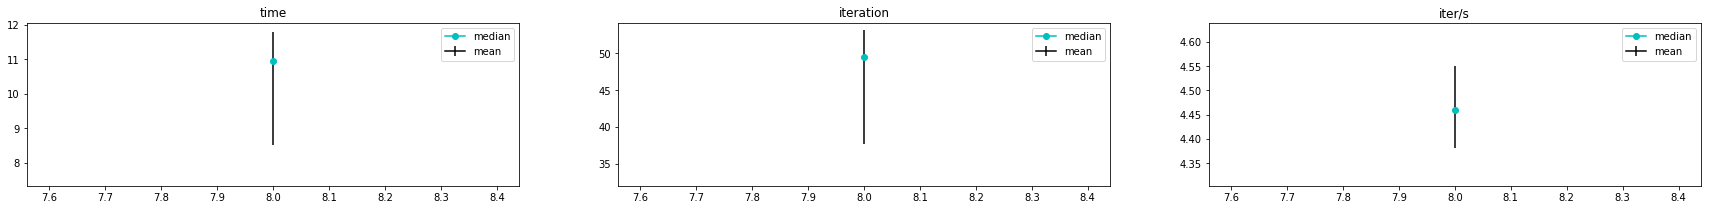

In [17]:
plt.figure(figsize=(30,3))
plt.subplot(1,3,1)
plot_band(plt, N_vec, times, title="time")
plt.subplot(1,3,2)
plot_band(plt, N_vec, iters, title="iteration")
plt.subplot(1,3,3)
plot_band(plt, N_vec, np.divide(iters, times), title="iter/s")
np.save("iteration_count/iterations", iters)
np.save("iteration_count/times", times)
np.save("iteration_count/numbers", N_vec)

In [ ]:
plt.plot(N_vec,np.mean(times,axis=1))
plt.plot(N_vec,np.median(times,axis=1))

In [ ]:
iters[0][0].value

In [ ]:
plt.plot(N_vec,np.mean(iters,axis=1))
plt.plot(N_vec,np.median(iters,axis=1))

In [ ]:
folder = "iteration_count/"
iters = np.load(folder+"iterations.npy")
times = np.load(folder+"times.npy")
N_vec = np.load(folder+"numbers.npy")
plt.figure(figsize=(30,10))
plt.subplot(1,3,1)
plot_band(plt, N_vec, times, title="time")
plt.grid()
plt.subplot(1,3,2)
plot_band(plt, N_vec, iters, title="iteration")
plt.grid()
plt.subplot(1,3,3)
plot_band(plt, N_vec, np.divide(iters, times), title="iter/s")

In [ ]:
folder = "iteration_count/bak/"
iters = np.load(folder+"iterations.npy")
times = np.load(folder+"times.npy")
N_vec = np.load(folder+"numbers.npy")
plt.figure(figsize=(30,10))
plt.subplot(1,3,1)
plot_band(plt, N_vec, times, title="time")
plt.grid()
plt.subplot(1,3,2)
plot_band(plt, N_vec, iters, title="iteration")
plt.grid()
plt.subplot(1,3,3)
plot_band(plt, N_vec, np.divide(iters, times), title="iter/s")

# simulate transitions

# Graph 

In [1]:
from __future__ import print_function
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; } </style>"))

In [2]:
from enum import Enum
class Scenario(Enum):
    single_object_single_robot = 0
    double_object_single_robot = 1
    single_object_dual_robot = 2
    assembly_3_piece = 3

In [3]:
current_scenario = Scenario.single_object_single_robot

In [4]:
if current_scenario in [Scenario.single_object_dual_robot, Scenario.assembly_3_piece]:
    from pkg.ur10_dual import URDF_PATH, JOINT_NAMES, LINK_NAMES, ZERO_JOINT_POSE, get_geometry_items_dict
else:
    from pkg.ur10 import URDF_PATH, JOINT_NAMES, LINK_NAMES, ZERO_JOINT_POSE, get_geometry_items_dict
from pkg.constraint_graph import *
import matplotlib.pyplot as plt
from pkg.plot_utils import *
from pkg.utils import *
# from threading import Thread, Lock
from multiprocessing import Process, Lock, Manager
PROC_MODE = True

In [84]:
graph = ConstraintGraph(urdf_path = URDF_PATH, joint_names = JOINT_NAMES, link_names = LINK_NAMES)
# graph.set_fixed_geometry_items(get_geometry_items_dict(graph.urdf_content, color=(0,1,0,0.5), display=False, collision=True))
graph.set_fixed_geometry_items({
        k:[] for k, v in get_geometry_items_dict(graph.urdf_content, color=(0,1,0,0.5), display=False, collision=False).items()})

# Single object

In [85]:
if current_scenario == Scenario.single_object_single_robot:
    collision = False
    graph.add_geometry_items("world", 
                              [
                               GeoMesh(uri="package://my_mesh/meshes/stl/AirPick_cup_ctd.stl", BLH=(0.01,0.01,0.01), scale=(1e-3,1e-3,1e-3), name="gripper1", link_name="tool0", urdf_content=graph.urdf_content, color=(0.1,0.1,0.1,1), collision=collision),
                               GeoBox((0.5,-0.2,0.050), (0.1,0.1,0.1), name="box1", link_name="world", urdf_content=graph.urdf_content, color=(0.3,0.3,0.8,1), collision=collision),
                               GeoBox((0,0,-0.005), (3,3,0.01), name="floor", link_name="world", urdf_content=graph.urdf_content, color=(0.6,0.6,0.6,1), collision=collision),
#                                GeoBox((0.7,0.0,0.2), (0.7,0.05,0.4), name="wall", link_name="world", urdf_content=graph.urdf_content, color=(0.4,0.3,0.0,1), collision=collision),
#                                GeoBox((0.4,0.4,0.15), (0.15,0.15,0.3), name="stepper", link_name="world", urdf_content=graph.urdf_content, color=(0.4,0.3,0.0,1), collision=collision),
#                                GeoBox((0.4,0.4,0.3), (0.1,0.1,1e-3), name="goal_disp", link_name="world", urdf_content=graph.urdf_content, color=(0.8,0.0,0.0,1),
#                                       collision=False)
        ])
    
    graph.register_binder(name='vac1', _type=VacuumTool, point=[0,0,5e-2], link_name="tool0", direction=[0,0,1])
    graph.register_binder(name='floor', _type=PlacePlane, direction=[0,0,1])
#     graph.register_binder(name='goal', _type=PlaceFrame, point=(0.4,0.4,0.3+5e-4), link_name="world", orientation=[0,0,0])

    graph.register_object('box1', _type=BoxAction, binding=("bottom_p","floor"))

    graph.update_handles()

# Set RVIZ

In [86]:
graph.set_simulation(nWSR=50, regularization_factor= 1e-1)

publication OK
published: [0, 0, 0, 0, 0, 0]
publication OK
publication OK
publication OK


# build

In [87]:
graph.build_graph()

In [88]:
if current_scenario == Scenario.single_object_single_robot:
    graph.search_graph_ordered(initial_state = \
                                  State((('box1','bottom_p','floor'),), 
                                        {'box1': [0.5,-0.2,0.05,0,0,0,1]}, ZERO_JOINT_POSE),
                                  goal_state = State((('box1','top_p','vac1'),), None, None), display=False, 
                                  terminate_on_first = True, tree_margin = 0,
                                  depth_margin = 2, joint_motion_num=50, 
                                  **dict(N=300, dt=0.01, vel_conv=1e-2, err_conv=1e-3))

init: 	40.0 ms/5 = 7.998 ms 
run: 	3023.0 ms/5 = 604.54 ms 
init_sim: 	252.0 ms/5 = 50.354 ms 
put_constraints: 	23.0 ms/5 = 4.579 ms 
monitor: 	5.0 ms/5 = 0.997 ms 
simulate: 	2726.0 ms/5 = 545.112 ms 
output: 	0.0 ms/5 = 0.027 ms 
post: 	3.0 ms/6 = 0.435 ms 
test: 	2668.0 ms/4 = 667.052 ms 
start set transition: 	1.0 ms/1 = 1.314 ms 
set_simulate fun: 	38.0 ms/1 = 38.073 ms 


success - Goal cost:1->0 / Init cost:0->1 / branching: 0->1 (0.04 s)
node: (('box1', 'bottom_p', 'floor'),)->(('box1', 'top_p', 'vac1'),)


In [19]:
len(graph.joint_names)

13

In [19]:
gtimer = GlobalTimer.instance()

In [20]:
N_list = [100]
mean_init = []
med_init = []
mean_run = []
med_run = []
mean_post = []
med_post = []

In [21]:
self = graph
from_state = graph.snode_vec[0].state
to_state = State((('box1', 'top_p', 'vac1'), ),None, None)
display=False
vel_conv=1e-2
err_conv=1e-3
error_skip=1e-6
lock=False
dt = 0.01
N_s = 1
JOINT_NAMES_SIMULATION = graph.joint_names

for N in N_list:
# N = 100
    kwargs = dict(N=N, dt=dt, vel_conv=1e-6)
    gtimer.reset()
    for _ in range(N_s):
        gtimer.tic("init")
        if from_state is not None:
            pos_start = from_state.Q
            self.set_object_state(from_state)

        additional_constraints = ""
        binding_list = []
        if to_state.node is not None:
            for bd0, bd1 in zip(from_state.node, to_state.node):
                if bd0[2] != bd1[2]:
                    additional_constraints += self.binder_dict[bd1[2]].make_constraints(self.object_dict[bd1[0]], bd1[1])
                    binding_list += [bd1]
                else:
                    assert bd0[1] == bd1[1] , "impossible transition"

        if additional_constraints=="" and to_state.Q is not None and np.sum(np.abs(np.subtract(to_state.Q,from_state.Q)))>1e-2:
        #             print('set joint constraint')
            kwargs.update(dict(additional_constraints=make_joint_constraints(joint_names=self.joint_names), 
                               inp_lbl=['target_%s'%jname for jname in self.joint_names], 
                               inp=list(to_state.Q)
                              ))                 
        else:
            kwargs.update(dict(additional_constraints=additional_constraints)
                         )

        init_text = get_init_text()

        if lock:
            self.lock.release()

        gtimer.toc("init")
        gtimer.tic("run")
        init_text=init_text
        initial_jpos=np.array(pos_start)
        err_conv=err_conv
        additional_constraints=kwargs['additional_constraints']
        vel_conv=vel_conv
        kwargs = {k:v for k,v in kwargs.items() if k not in ['additional_constraints', 'vel_conv']}
        
        gtimer.tic("init_sim")
        etasl = get_simulation(init_text)
        gtimer.toc("init_sim")
        gtimer.tic("put_constraints")
        etasl.readTaskSpecificationString(additional_constraints)
        gtimer.toc("put_constraints")

        gtimer.tic("monitor")
        vel_statement=""
        for i in range(len(JOINT_NAMES_SIMULATION)):
            vel_statement += 'abs(previous_velocity(time, robot_jval[{index}]))+'\
                .format(index = i+1, joint_name=JOINT_NAMES_SIMULATION[i])
        vel_val = """
            vel_joints = maximum(1-time, {})
            """.format(vel_statement[:-1])
        monitor_string = vel_val + \
            """
            ctx:setOutputExpression("vel_joints",vel_joints)
            Monitor {{
                context = ctx,
                name = "converged",
                expr   = vel_joints,
                lower = {vel_conv},
                actionname ="exit",
                argument = "converged"
            }}
            """.format(vel_conv=vel_conv)
        if "error_target" in additional_constraints:
            monitor_string += \
                """
                Monitor {{
                    context = ctx,
                    name = "goal_reached",
                    expr   = error_target,
                    lower = {err_conv},
                    actionname ="exit",
                    argument = "e_arrived"
                }}
                """.format(err_conv=err_conv)
        etasl.readTaskSpecificationString(monitor_string)
        gtimer.toc("monitor")
        gtimer.tic("simulate")
        simulate(etasl=etasl, initial_jpos=initial_jpos, **kwargs)
        gtimer.toc("simulate")
        gtimer.tic("simulate2")
        simulate(etasl=etasl, initial_jpos=initial_jpos, **kwargs)
        gtimer.toc("simulate2")
        gtimer.tic("output")
        etasl.joint_dict_last = joint_list2dict(etasl.POS[-1], JOINT_NAMES_SIMULATION)
        output = etasl.etasl.getOutput()
        if 'global.error' in output:
            etasl.error = output['global.error']
        gtimer.toc("output")
        e = etasl
        
        
        gtimer.toc("run")
        gtimer.tic("post")

        if lock:
            self.lock.acquire()


        if from_state is not None:
            self.set_object_state(from_state)
        if display:
            if len(e.POS)>1:
                show_motion(e.POS, self.marker_list, self.pub, self.joints, self.joint_names, error_skip=1e-4)
        if hasattr(e, 'error') and e.error<err_conv:
            success = True
            for bd in binding_list:
                self.rebind(bd, e.joint_dict_last)

        else:
            success = False
        node, obj_pos_dict = self.get_object_state()
        end_state = State(node, obj_pos_dict, list(e.POS[-1]))
        gtimer.toc("post")
        e, end_state, succ = e, end_state, success
    mean_init += [gtimer.time_dict["init"]/N_s]
    mean_run += [gtimer.time_dict["run"]/N_s]
    mean_post += [gtimer.time_dict["post"]/N_s]
    print(gtimer)

init: 	1.0 ms/1 = 0.861 ms 
run: 	125.0 ms/1 = 124.84 ms 
init_sim: 	14.0 ms/1 = 13.671 ms 
put_constraints: 	5.0 ms/1 = 5.328 ms 
monitor: 	2.0 ms/1 = 2.192 ms 
simulate: 	53.0 ms/1 = 52.87 ms 
simulate2: 	51.0 ms/1 = 50.702 ms 
output: 	0.0 ms/1 = 0.023 ms 
post: 	0.0 ms/1 = 0.053 ms 



In [28]:
print(init_text)


        require("context")
        require("geometric")
        --require("libexpressiongraph_collision")
        require("collision")
        require("libexpressiongraph_velocities")
        local u=UrdfExpr();
        local fn = "/home/junsu/Projects/tamp_etasl/eTaSL/robots/custom_robots.urdf"
        u:readFromFile(fn)
    
        margin=0.0001
        radius=0.0
        error_target=0
        u:addTransform("T_world","world","world")
    u:addTransform("T_indy0_link0","indy0_link0","world")
    u:addTransform("T_indy0_link1","indy0_link1","world")
    u:addTransform("T_indy0_link2","indy0_link2","world")
    u:addTransform("T_indy0_link3","indy0_link3","world")
    u:addTransform("T_indy0_link4","indy0_link4","world")
    u:addTransform("T_indy0_link5","indy0_link5","world")
    u:addTransform("T_indy0_link6","indy0_link6","world")
    u:addTransform("T_indy0_tcp","indy0_tcp","world")
    u:addTransform("T_panda1_link0","panda1_link0","world")
    u:addTransform("T_panda1_link1",

In [ ]:
addi

In [26]:
e.POS[-1]

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  4.98597935e-01,  1.60783995e+00,
        2.06384312e-01, -1.91483025e-01, -2.26819428e-01,  1.72500259e+00,
       -2.69137391e-07,  0.00000000e+00,  0.00000000e+00])

In [25]:
initial_jpos.shape

(13,)

In [23]:
e.POS.shape

(100, 15)

In [98]:
for _ in range(N_s):
    gtimer.tic("recycle")
    simulate(etasl=etasl, initial_jpos=initial_jpos, **kwargs)
    gtimer.toc("recycle")
print(gtimer)

init: 	3.0 ms/5 = 0.502 ms 
run: 	1656.0 ms/5 = 331.168 ms 
init_sim: 	30.0 ms/5 = 6.091 ms 
put_constraints: 	26.0 ms/5 = 5.274 ms 
monitor: 	5.0 ms/5 = 1.063 ms 
simulate: 	779.0 ms/5 = 155.813 ms 
simulate2: 	808.0 ms/5 = 161.524 ms 
output: 	0.0 ms/5 = 0.017 ms 
post: 	0.0 ms/5 = 0.054 ms 
recycle: 	936.0 ms/5 = 187.123 ms 



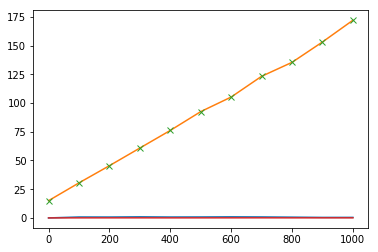

In [71]:
y_int = 15
plt.plot([0]+N_list, [0]+mean_init)
plt.plot([0]+N_list, [y_int]+mean_run)
plt.plot([0]+N_list, [y_int]+mean_run,'x')
plt.plot([0]+N_list, [0]+mean_post)

In [12]:
print(init_text)
print(kwargs['additional_constraints'])


        require("context")
        require("geometric")
        --require("libexpressiongraph_collision")
        require("collision")
        require("libexpressiongraph_velocities")
        local u=UrdfExpr();
        local fn = "/home/junsu/Projects/tamp_etasl/eTaSL/robots/ur10_robot.urdf"
        u:readFromFile(fn)
    
        margin=0.0001
        radius=0.0
        error_target=0
        u:addTransform("T_world","world","world")
    u:addTransform("T_base_link","base_link","world")
    u:addTransform("T_shoulder_link","shoulder_link","world")
    u:addTransform("T_upper_arm_link","upper_arm_link","world")
    u:addTransform("T_forearm_link","forearm_link","world")
    u:addTransform("T_wrist_1_link","wrist_1_link","world")
    u:addTransform("T_wrist_2_link","wrist_2_link","world")
    u:addTransform("T_wrist_3_link","wrist_3_link","world")
    u:addTransform("T_tool0","tool0","world")

        local r = u:getExpressions(ctx)
        T_world = r.T_world
    T_base_link = r.T_ba

In [13]:
N = 300
dt = 0.01

t1 = timer.time()
e, end_state, succ = graph.simulate_transition(from_state, to_state, display=False, N=N, dt=dt, vel_conv=1e-6, err_conv=1e-6)
t2 = timer.time()
print("%.2f ms"%((t2-t1)*1000))
e, end_state, succ = graph.simulate_transition(from_state, to_state, display=True, N=N, dt=dt, vel_conv=1e-2, err_conv=1e-3)
print(succ)

start set transition: 	3.0 ms/2 = 1.705 ms 
set_simulate fun: 	106.0 ms/2 = 53.161 ms 
post: 	0.0 ms/2 = 0.166 ms 

80.76 ms
start set transition: 	4.0 ms/3 = 1.395 ms 
set_simulate fun: 	128.0 ms/3 = 42.578 ms 
post: 	202.0 ms/3 = 67.271 ms 

True


In [18]:

node, obj_pos_dict = graph.get_object_state()
end_state = State(node, obj_pos_dict, list(e.POS[-1]))

NameError: name 'e' is not defined

In [18]:
from_state = end_state
to_state = State((('box1', 'top_p', 'vac1'), ),None, None)
# to_state = end_state.copy()
# to_state.Q = ZERO_JOINT_POSE

In [19]:
N = 1000
dt = 0.01

t1 = timer.time()
e, end_state, succ = graph.simulate_transition(from_state, to_state, display=False, N=N, dt=dt, vel_conv=1e-2, err_conv=6e-3)
t2 = timer.time()
print("%.2f ms"%((t2-t1)*1000))
e, end_state, succ = graph.simulate_transition(from_state, to_state, display=True, N=N, dt=dt, vel_conv=1e-2, err_conv=6e-3)
print(succ)

NotImplementedError: 

In [ ]:
e.error

In [ ]:
print(end_state)

In [ ]:
from_state = end_state
to_state = from_state.copy()
to_state.Q = ZERO_JOINT_POSE

In [ ]:
N = 300
dt = 0.01

t1 = timer.time()
e, end_state, succ = graph.simulate_transition(from_state, to_state, display=False, N=N, dt=dt, vel_conv=1e-2, err_conv=1e-3)
t2 = timer.time()
print("%.2f ms"%((t2-t1)*1000))
e, end_state, succ = graph.simulate_transition(from_state, to_state, display=True, N=N, dt=dt, vel_conv=1e-2, err_conv=1e-3)
print(succ)

In [ ]:
graph.binder_dict

In [ ]:
from_state = State((('box1', 'top_p', 'box2'), ('box2', 'bottom_p', 'vac1')),
                   {'box1': (0, 0, 0.2, 0.0, -0.0, 0.0, 1),
                    'box2': (0, 0, 0.1, 0.0, -0.0, -0.0, 1)}, ZERO_JOINT_POSE)

In [ ]:
to_state = State((('box1', 'top_p', 'box2'), ('box2', 'bottom_p', 'vac1')),
                   {'box1': (0, 0, 0.2, 0.0, -0.0, 0.0, 1),
                    'box2': (0, 0, 0.1, 0.0, -0.0, -0.0, 1)}, [ 0.        , -np.pi/2,  np.pi/2,  0.        ,  0.        , 0.]        )

In [ ]:
from_state = State((('box1', 'bottom_p', 'box2'), ('box2', 'bottom_p', 'vac1')), {'box1': [-0.03, -0.39 , 0.45, 0.,   -0. ,   0.56,  0.83], 'box2': [-0.1,  -0.4 ,  0.35 , 0. ,  -0. ,  -0.34 , 0.94]}, [-2.08, -2.13,  2.22, -1.66, -1.57,  0.03])
to_state = State((('box1', 'bottom_p', 'box2'), ('box2', 'bottom_p', 'vac1')), {'box1': [-0.03, -0.39,  0.45,  0.,   -0. ,   0.56,  0.83], 'box2': [-0.1  ,-0.4 ,  0.35  ,0.,   -0. ,  -0.34 , 0.94]}, ZERO_JOINT_POSE)

In [ ]:
## N = 100
dt = 0.02

t1 = timer.time()
e, end_state, succ = graph.simulate_transition(from_state, to_state, display=False, N=N, dt=dt)
t2 = timer.time()
print("%.2f ms"%((t2-t1)*1000))
e, end_state, succ = graph.simulate_transition(from_state, to_state, display=True, N=N, dt=dt)
print(succ)

In [ ]:
N = 300
dt = 0.01

t1 = timer.time()
e, end_state, succ = graph.simulate_transition(from_state, to_state, display=False, N=N, dt=dt, vel_conv=1e-2, err_conv=1e-3)
t2 = timer.time()
print("%.2f ms"%((t2-t1)*1000))
e, end_state, succ = graph.simulate_transition(from_state, to_state, display=True, N=N, dt=dt, vel_conv=1e-2, err_conv=1e-3)
print(succ)

In [ ]:
from_state = State((('box1','bottom_p','floor'),), 
                      {'box1': [0.5,-0.2,0.05,0,0,0,1]}, ZERO_JOINT_POSE
                     )
to_state = State((('box1','top_p','vac1'),), None, None)
N = 100
dt = 0.02

t1 = timer.time()
e, end_state, succ = graph.simulate_transition(from_state, to_state, display=False, N=N, dt=dt)
t2 = timer.time()
print("%.2f ms"%((t2-t1)*1000))
e, end_state, succ = graph.simulate_transition(from_state, to_state, display=True, N=N, dt=dt)
print(succ)

In [ ]:
from_state = end_state
to_state = State((('box1','top_p','vac1'),), 
                      None, ZERO_JOINT_POSE)
e, end_state, succ = graph.simulate_transition(from_state, to_state, display=True)
print(succ)

In [ ]:
from_state = end_state
to_state = State((('box1','bottom_f','goal'),), None, None)
e, end_state, succ = graph.simulate_transition(from_state, to_state, display=True)
print(succ)

In [ ]:
from_state = end_state
to_state = end_state.copy()
to_state.Q = ZERO_JOINT_POSE
e, end_state, succ = graph.simulate_transition(from_state, to_state, display=True)

In [ ]:
graph.binder_dict['box2'].object

In [ ]:
graph.object_dict['box2'].object

# delete all

In [ ]:
for mkr in marker_list:
    mkr.delete()

# Plotting (using the Bokeh library to provide interactive plots)

In [ ]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.layouts import gridplot
from etasl_py.bokehplots import plotv

output_notebook()
print("positions : ")
plotv(e.TIME,e.POS,e.POS_LBL)
print("velocities : ")
plotv(e.TIME,e.VEL,e.POS_LBL)
print("outputs : ")
plotv(e.TIME,e.OUTP,e.OUTP_LBL)

In [ ]:
!urdf_to_graphiz $(rospack find etasl_py_examples)/robots/ur10_robot.urdf
from graphviz import Source
Source.from_file('ur10.gv')